In [1]:
!pip install fuzzy-c-means

     |████████████████████████████████| 10.1 MB 5.3 MB/s 
     |████████████████████████████████| 15.7 MB 26.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the libraries

In [3]:
# %cd '/content/drive/MyDrive/Projects/DMG_Assignment/Assignment_3/'
%cd '/content/drive/MyDrive/DMG_Assignment/Assignment_3/'

/content/drive/.shortcut-targets-by-id/18sFl4FL5B61beZh_kJ0D1bndguJgrGW3/DMG_Assignment/Assignment_3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import *
import pickle
from fcmeans import FCM
import plotly.express as px
import Inference
from tabulate import tabulate

ModuleNotFoundError: ignored

In [5]:
import importlib
importlib.reload(Inference)

<module 'Inference' from '/content/drive/.shortcut-targets-by-id/18sFl4FL5B61beZh_kJ0D1bndguJgrGW3/DMG_Assignment/Assignment_3/Inference.py'>

# Load dataset

In [6]:
# Amulya
path = '/content/drive/MyDrive/DMG_Assignment/Assignment_3/covtype_train.csv'

# Aniket 
# path = '/content/drive/MyDrive/Projects/DMG_Assignment/Assignment_3/covtype_train.csv'

data = pd.read_csv(path)
data.head()

,Elevation,Aspect,Slope,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness,target
0,elevation_medium,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,0,1,low,22,0,2
1,elevation_high,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,1,1,mid,32,2,1
2,elevation_medium,aspect_low,slope_low,hillshade_9am_max,hillnoon_max,1,1,low,10,2,2
3,elevation_high,aspect_ultra,slope_medium,hillshade_9am_max,hillnoon_max,2,1,low,23,2,1
4,elevation_high,aspect_high,slope_low,hillshade_9am_max,hillnoon_max,2,1,mid,28,0,2


# Data statistics

In [7]:
data.dtypes

Elevation                             object
Aspect                                object
Slope                                 object
Hillshade_9am                         object
Hillshade_Noon                        object
Horizontal_Distance_To_Hydrology       int64
Vertical_Distance_To_Hydrology         int64
Horizontal_Distance_To_Fire_Points    object
Soil_Type                              int64
Wilderness                             int64
target                                 int64
dtype: object

In [8]:
data.describe

<bound method NDFrame.describe of                Elevation         Aspect  ... Wilderness target
0       elevation_medium  aspect_medium  ...          0      2
1         elevation_high  aspect_medium  ...          2      1
2       elevation_medium     aspect_low  ...          2      2
3         elevation_high   aspect_ultra  ...          2      1
4         elevation_high    aspect_high  ...          0      2
...                  ...            ...  ...        ...    ...
406703   elevation_ultra  aspect_medium  ...          0      7
406704  elevation_medium     aspect_low  ...          0      2
406705  elevation_medium  aspect_medium  ...          0      2
406706    elevation_high    aspect_high  ...          0      2
406707  elevation_medium   aspect_ultra  ...          2      2

[406708 rows x 11 columns]>

In [9]:
col = data.columns
print(col)

Index(['Elevation', 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type', 'Wilderness',
       'target'],
      dtype='object')


In [10]:
def counting(data, col):
  for i in col:
    if data[i].dtype=='object':
      print('For column = ',i,' , possible values with counts \n',data[i].value_counts())
      print()
counting(data, col)

For column =  Elevation  , possible values with counts 
 elevation_high      269875
elevation_medium    104565
elevation_low        16465
elevation_ultra      15803
Name: Elevation, dtype: int64

For column =  Aspect  , possible values with counts 
 aspect_low       152176
aspect_medium     99683
aspect_ultra      96212
aspect_high       58637
Name: Aspect, dtype: int64

For column =  Slope  , possible values with counts 
 slope_low       275301
slope_medium    122872
slope_high        8471
slope_ultra         64
Name: Slope, dtype: int64

For column =  Hillshade_9am  , possible values with counts 
 hillshade_9am_max    402697
hillshade_9am_min      4011
Name: Hillshade_9am, dtype: int64

For column =  Hillshade_Noon  , possible values with counts 
 hillnoon_max    406421
hillnoon_min       287
Name: Hillshade_Noon, dtype: int64

For column =  Horizontal_Distance_To_Fire_Points  , possible values with counts 
 low     287676
mid      96456
high     22576
Name: Horizontal_Distance_To_Fi

In [11]:
print(data['target'].value_counts())

2    198310
1    148288
3     25028
7     14357
6     12157
5      6645
4      1923
Name: target, dtype: int64


# Data Encoding

In [3]:
def encoding_data(data):
  mapping = {"elevation_high":2, "elevation_medium":1, "elevation_low":0, "elevation_ultra":3}
  data["Elevation"] = data["Elevation"].replace(mapping)

  mapping = {"aspect_high":2, "aspect_medium":1, "aspect_low":0, "aspect_ultra":3}
  data["Aspect"] = data["Aspect"].replace(mapping)

  mapping = {"slope_high":2, "slope_medium":1, "slope_low":0, "slope_ultra":3}
  data["Slope"] = data["Slope"].replace(mapping)

  mapping = {"hillshade_9am_max":1, "hillshade_9am_min":0}
  data["Hillshade_9am"] = data["Hillshade_9am"].replace(mapping)

  mapping = {"hillnoon_max":1, "hillnoon_min":0}
  data["Hillshade_Noon"] = data["Hillshade_Noon"].replace(mapping)

  mapping = {"high":2,"mid":1 ,"low":0}
  data["Horizontal_Distance_To_Fire_Points"] = data["Horizontal_Distance_To_Fire_Points"].replace(mapping)
# encoding_data(data)

# Data Preprocessing and Splitting

In [13]:
y = np.array(data['target'])
data.drop(['target'],axis = 1)
X = np.array(data)
y_d = y - 1

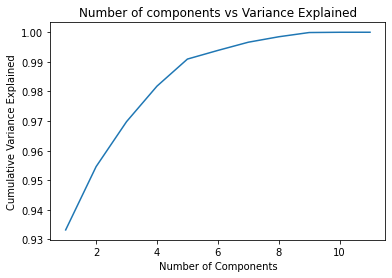

In [14]:
X_pca = PCA()
X_pca.fit(X)

X_axis = np.arange(1,X.shape[1]+1,1)
Y_axis = np.cumsum(X_pca.explained_variance_ratio_)
plt.plot(X_axis,Y_axis)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Number of components vs Variance Explained')
plt.show()

X_pca = PCA(n_components=5).fit_transform(X)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y_d, test_size=0.3, random_state=42)

# Clustering

## KMeans

In [ ]:
# KM = KMeans(n_clusters =len(set(y)) , max_iter = 500 , random_state = 42)
# KM.fit(X_train)
# print("Balanced F1 Score : "+str(f1_score(y_val,KM.predict(X_val) , average='micro')))

## Fuzzy C - Means

In [ ]:
# fcm = FCM(n_clusters=7)
# fcm.fit(X_train)
# y_pred = fcm.predict(X_val)
# print("Balanced F1 Score : "+str(f1_score(y_val , y_pred , average='micro')))

## BIRCH

In [ ]:
# model = Birch(threshold=0.1, n_clusters=7)
# model.fit(X_train)
# y_pred = model.predict(X_val)
# print("Balanced F1 Score : "+str(f1_score(y_val , y_pred , average='micro')))

## Gaussian Mixture Method

In [ ]:
# modelg = GaussianMixture(n_components=len(set(y)),random_state=33)
# modelg.fit(X_train)
# y_pred = modelg.predict(X_val)
# print(f1_score(y_val , y_pred , average='micro'))

# Saving Models

In [ ]:
# filename = '/content/drive/MyDrive/Projects/DMG_Assignment/Assignment_3/'
# pickle.dump(KM, open(filename+'kmeans.pkl', 'wb'))
# pickle.dump(fcm, open(filename+'fuzzycm.pkl', 'wb'))
# pickle.dump(model, open(filename+'birch.pkl', 'wb'))
# pickle.dump(modelg, open(filename+'gm.pkl', 'wb'))

# Loading Models

In [16]:
# filename = '/content/drive/MyDrive/Projects/DMG_Assignment/Assignment_3/'
filename = '/content/drive/MyDrive/DMG_Assignment/Assignment_3/'
KM = pickle.load(open(filename+'kmeans.pkl', 'rb'))
fcm = pickle.load(open(filename+'fuzzycm.pkl', 'rb'))
model = pickle.load(open(filename+'birch.pkl', 'rb'))
modelg = pickle.load(open(filename+'gm.pkl', 'rb'))

# Prediction Model

In [17]:
def getdict(X,y_train , y_pred):
  arr = {}
  arrm = {}
  for j in range(7):
    a = np.zeros(7)
    for i in range(len(X)):
      if y_pred[i] == j:
        a[y_train[i]] += 1
    t = list(a)    
    arr[j] = t
    arrm[j] = t.index(max(t))
  return arr , arrm

In [19]:
y_predkm = KM.predict(X_train)
y_predfcm = fcm.predict(X_train)
y_predmodel = model.predict(X_train)
y_pred_modelg = model.predict(X_train)

arrkm , mc1 = getdict(X_train,y_train, y_predkm)
arrfcm , mc2 = getdict(X_train,y_train, y_predfcm)
arrmodel , mc3 = getdict(X_train,y_train, y_predmodel)
arrmodelg , mc4 = getdict(X_train,y_train, y_pred_modelg)

# Prediction and F1 score 

In [20]:
def pred(X,model,dicti):
  y_pred = model.predict(X)
  final_pred = []
  for i in range(len(X)):
    final_pred.append(dicti[y_pred[i]])
  return final_pred  

y_pred = pred(X_val,KM,mc1)
print("With KMeans , Balanced F1 Score : "+str(f1_score(y_val,y_pred, average='micro')))

y_pred = pred(X_val,fcm,mc2)
print("With Fuzzy C - Means , Balanced F1 Score : "+str(f1_score(y_val,y_pred, average='micro')))

y_pred = pred(X_val,model,mc3)
print("With Birch , Balanced F1 Score : "+str(f1_score(y_val,y_pred, average='micro')))

y_pred = pred(X_val,modelg,mc4)
print("With Gaussian Mixture Method , Balanced F1 Score : "+str(f1_score(y_val,y_pred, average='micro')))


With KMeans , Balanced F1 Score : 0.632285084376255
With Fuzzy C - Means , Balanced F1 Score : 0.5717013760828764
With Birch , Balanced F1 Score : 0.6341619335644563
With Gaussian Mixture Method , Balanced F1 Score : 0.4094481735552769


# Centroids and Visualization of the clusters

In [21]:
def plotscatter(centers,X,model,nop):
  
  fcm_labels = model.predict(X[:nop])
  plt.figure(figsize=(10,8))
  plt.scatter(X[:nop,0], X[:nop,1], c = fcm_labels,alpha=0.8)
  plt.scatter(centers[:,0], centers[:,1], marker="*", s=1000, c='black')
  plt.show()

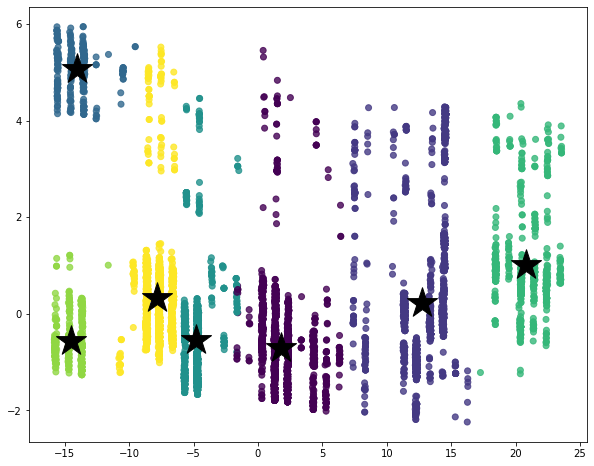

In [22]:
km_centers = KM.cluster_centers_
plotscatter(km_centers,X_train,KM,10000)

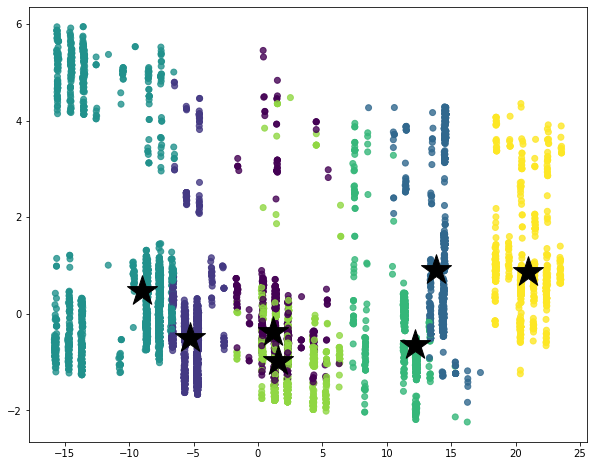

In [23]:
fcm_centers = fcm.centers
plotscatter(fcm_centers,X_train,fcm,10000)

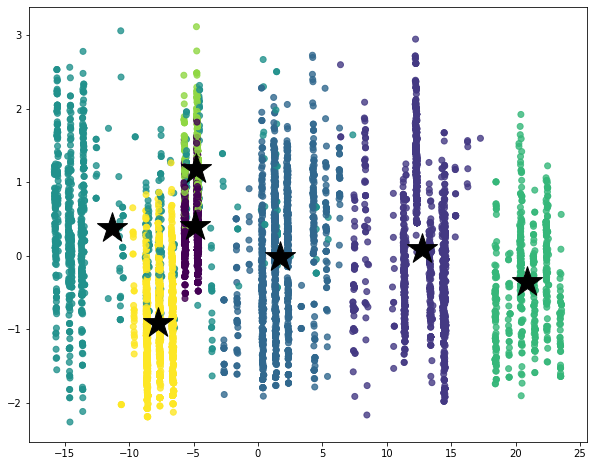

In [24]:
nop = 10000
brich_labels = modelg.predict(X_train[:nop])
centers = modelg.means_
plt.figure(figsize=(10,8))
plt.scatter(X_train[:nop,0], X_train[:nop,4], c = brich_labels,alpha=0.8)
plt.scatter(centers[:,0], centers[:,4], marker="*", s=1000, c='black')
plt.show()

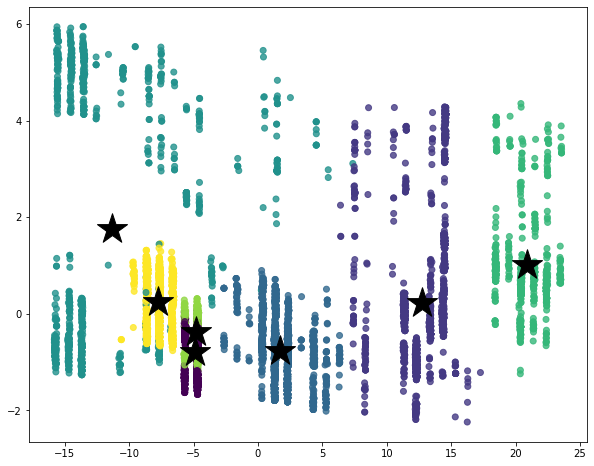

In [25]:
gp_cen = modelg.means_
plotscatter(gp_cen,X_train,modelg,10000)

# Distribution of classes inside cluster centers

In [26]:
print('Distribution of classes inside cluster centers for KMeans : ')
for i,j in arrkm.items():
  print('Cluster : ',i,' , distrubtion : ',j)
print()  

print('Distribution of classes inside cluster centers for Fuzzy Clustering : ')
for i,j in arrfcm.items():
  print('Cluster : ',i,' , distrubtion : ',j)
print()

print('Distribution of classes inside cluster centers for BIRCH : ')
for i,j in arrmodel.items():
  print('Cluster : ',i,' , distrubtion : ',j)
print()

print('Distribution of classes inside cluster centers for Gaussian Mixture Model : ')
for i,j in arrmodelg.items():
  print('Cluster : ',i,' , distrubtion : ',j)      
print()  

Distribution of classes inside cluster centers for KMeans : 
Cluster :  0  , distrubtion :  [39164.0, 23413.0, 0.0, 0.0, 517.0, 220.0, 508.0]
Cluster :  1  , distrubtion :  [3769.0, 31706.0, 6698.0, 449.0, 1387.0, 5503.0, 2.0]
Cluster :  2  , distrubtion :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8164.0]
Cluster :  3  , distrubtion :  [24546.0, 46029.0, 0.0, 0.0, 1628.0, 0.0, 512.0]
Cluster :  4  , distrubtion :  [97.0, 3067.0, 10836.0, 927.0, 426.0, 2333.0, 37.0]
Cluster :  5  , distrubtion :  [10445.0, 704.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cluster :  6  , distrubtion :  [25592.0, 34059.0, 60.0, 0.0, 680.0, 400.0, 817.0]

Distribution of classes inside cluster centers for Fuzzy Clustering : 
Cluster :  0  , distrubtion :  [16436.0, 9789.0, 0.0, 0.0, 355.0, 97.0, 295.0]
Cluster :  1  , distrubtion :  [28543.0, 48949.0, 0.0, 0.0, 1623.0, 7.0, 540.0]
Cluster :  2  , distrubtion :  [527.0, 9838.0, 6304.0, 171.0, 1043.0, 5040.0, 2.0]
Cluster :  3  , distrubtion :  [32037.0, 31190.0, 60.0, 0.0, 609.0, 393

In [27]:
dfkmeans = pd.DataFrame(columns=["Cluster","Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7"])
dffcm = pd.DataFrame(columns=["Cluster","Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7"])
dfmodel = pd.DataFrame(columns=["Cluster","Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7"])
dfmodelg = pd.DataFrame(columns=["Cluster","Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7"])

for i,j in arrkm.items():
  dfkmeans.loc[len(dfkmeans)] = list(str(i)) + j
for i,j in arrfcm.items():
  dffcm.loc[len(dffcm)] = list(str(i)) + j
for i,j in arrmodel.items():
  dfmodel.loc[len(dfmodel)] = list(str(i)) + j
for i,j in arrmodelg.items():
  dfmodelg.loc[len(dfmodelg)] = list(str(i)) + j

In [28]:
print('Distribution of classes inside cluster centers for KMeans : ')
print(tabulate(dfkmeans, headers='keys', tablefmt='psql')) 

print('Distribution of classes inside cluster centers for Fuzzy Clustering : ')
print(tabulate(dffcm, headers='keys', tablefmt='psql')) 

print('Distribution of classes inside cluster centers for BIRCH : ')
print(tabulate(dfmodel, headers='keys', tablefmt='psql')) 

print('Distribution of classes inside cluster centers for Gaussian Mixture Model : ')
print(tabulate(dfmodelg, headers='keys', tablefmt='psql')) 

Distribution of classes inside cluster centers for KMeans : 
+----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|    |   Cluster |   Class 1 |   Class 2 |   Class 3 |   Class 4 |   Class 5 |   Class 6 |   Class 7 |
|----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------|
|  0 |         0 |     39164 |     23413 |         0 |         0 |       517 |       220 |       508 |
|  1 |         1 |      3769 |     31706 |      6698 |       449 |      1387 |      5503 |         2 |
|  2 |         2 |         0 |         0 |         0 |         0 |         0 |         0 |      8164 |
|  3 |         3 |     24546 |     46029 |         0 |         0 |      1628 |         0 |       512 |
|  4 |         4 |        97 |      3067 |     10836 |       927 |       426 |      2333 |        37 |
|  5 |         5 |     10445 |       704 |         0 |         0 |         0 |         0 |         0 |
|  6 |      

# Running Inference.py

In [ ]:
pred = Inference.predict(X)

In [ ]:
print(pred)

[0, 6, 1, 0, 3, 3, 1, 0, 3, 0, 5, 6, 3, 1, 6, 3, 3, 0, 3, 6, 6, 6, 0, 0, 1, 3, 1, 1, 0, 4, 3, 6, 1, 0, 3, 3, 3, 2, 3, 0, 3, 6, 1, 0, 5, 3, 3, 0, 0, 3, 0, 0, 6, 4, 3, 3, 0, 6, 3, 0, 1, 3, 0, 6, 0, 0, 3, 6, 1, 6, 0, 5, 4, 6, 1, 3, 3, 6, 5, 6, 0, 5, 1, 1, 3, 0, 4, 3, 1, 2, 5, 3, 5, 3, 6, 1, 6, 3, 0, 2, 6, 6, 4, 0, 3, 3, 1, 6, 3, 3, 0, 6, 0, 4, 6, 0, 3, 1, 5, 3, 1, 1, 2, 0, 1, 0, 3, 0, 0, 3, 1, 0, 3, 0, 0, 6, 6, 0, 6, 6, 6, 4, 3, 3, 3, 1, 1, 3, 0, 1, 0, 6, 3, 6, 0, 0, 1, 0, 5, 3, 3, 3, 2, 1, 0, 0, 6, 0, 0, 3, 1, 1, 4, 5, 3, 0, 6, 3, 1, 3, 0, 6, 5, 1, 0, 1, 3, 0, 1, 0, 1, 3, 6, 6, 0, 3, 0, 6, 1, 3, 2, 5, 3, 3, 6, 6, 1, 3, 4, 2, 1, 0, 2, 0, 0, 6, 1, 6, 6, 6, 4, 3, 0, 3, 0, 3, 0, 0, 6, 5, 3, 3, 6, 6, 4, 3, 6, 3, 4, 4, 3, 0, 3, 6, 3, 0, 1, 3, 1, 0, 6, 6, 4, 3, 3, 6, 6, 4, 0, 1, 3, 0, 6, 0, 6, 3, 3, 0, 1, 3, 1, 6, 6, 1, 3, 4, 3, 1, 6, 0, 0, 3, 6, 6, 0, 3, 0, 6, 0, 0, 6, 3, 1, 3, 1, 6, 0, 6, 0, 3, 2, 4, 6, 0, 3, 1, 4, 0, 3, 4, 6, 4, 3, 0, 6, 0, 3, 3, 6, 4, 3, 1, 5, 3, 3, 2, 3, 0, 3, 3, 6, 6, 0, 

# Given test Set

In [4]:
test_data = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set.csv")
#encode the test_data
encoding_data(test_data)
#perform PCA
test_data = PCA(n_components=5).fit_transform(test_data)

## Preloaded

In [ ]:
#load pre-existing model
# filename = '/content/drive/MyDrive/Projects/DMG_Assignment/Assignment_3/'
filename = '/content/drive/MyDrive/DMG_Assignment/Assignment_3/'
KM = pickle.load(open(filename+'kmeans.pkl', 'rb'))
fcm = pickle.load(open(filename+'fuzzycm.pkl', 'rb'))
model = pickle.load(open(filename+'birch.pkl', 'rb'))
modelg = pickle.load(open(filename+'gm.pkl', 'rb'))
#predicting with the models
# y_predkm = KM.predict(test_data)
# y_predfcm = fcm.predict(test_data)
# y_predmodel = model.predict(test_data)
# y_pred_modelg = model.predict(test_data)

In [ ]:
output = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
output['target'] = y_predkm

,id,target
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5


In [ ]:
output['target'].value_counts()

4    87136
5    87102
2       40
1        9
0        8
3        7
6        2
Name: target, dtype: int64

In [ ]:
out = output.to_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv",index = False)

In [ ]:
reading = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
reading

,id,target
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
...,...,...
174299,174299,4
174300,174300,4
174301,174301,4
174302,174302,4


In [7]:
def plotscatter(centers,X,fcm_labels,model,nop):
  plt.figure(figsize=(10,8))
  plt.scatter(X[:nop,1], X[:nop,4], c = fcm_labels,alpha=0.8)
  plt.scatter(centers[:,1], centers[:,4], marker="*", s=1000, c='black')
  plt.show()

## New fitting

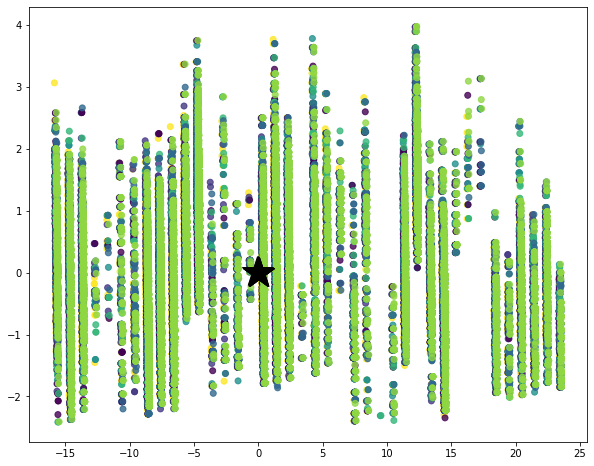

In [36]:
KM = KMeans(n_clusters = 7 , max_iter = 500 , random_state = 42)
KM.fit(test_data)
y_p = KM.predict(test_data)
km_centers = KM.cluster_centers_
plotscatter(km_centers,test_data,y_p,KM,174304)

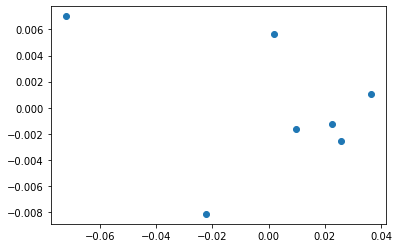

In [37]:
plt.scatter(km_centers[:,1], km_centers[:,4])

In [38]:
output = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
output['target'] = y_p
output['target'].value_counts()

0    25296
3    25214
4    25078
1    24933
6    24693
2    24693
5    24397
Name: target, dtype: int64

In [ ]:
fcm = FCM(n_clusters=7)
fcm.fit(test_data)
y_pf = fcm.predict(test_data)
output = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
output['target'] = y_pf
output['target'].value_counts()

6    25607
0    25549
4    25546
3    25251
2    25246
1    23555
5    23550
Name: target, dtype: int64

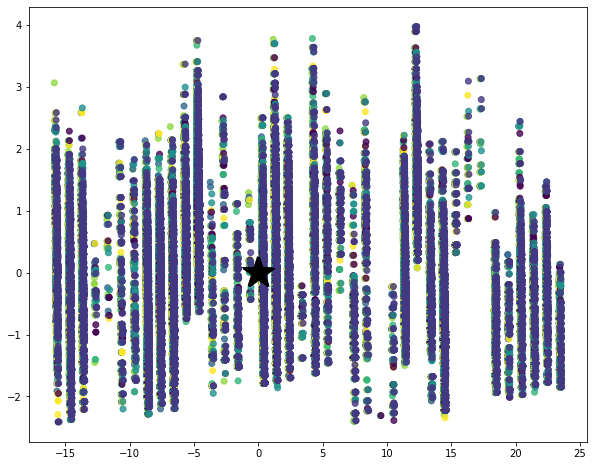

In [ ]:
fcm_centers = fcm.centers
plotscatter(fcm_centers,test_data,y_pf,fcm,174304)

In [ ]:
model = Birch(threshold=0.1, n_clusters=7)
model.fit(test_data)
y_b = model.predict(test_data)
output = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
output['target'] = y_b
output['target'].value_counts()

In [14]:
modelg = GaussianMixture(n_components=7,random_state=33)
modelg.fit(test_data)
y_pg = modelg.predict(test_data)
output = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
output['target'] = y_pg+1
output['target'].value_counts()

3    70072
6    54588
2    18592
5    10468
7     9409
1     5997
4     5178
Name: target, dtype: int64

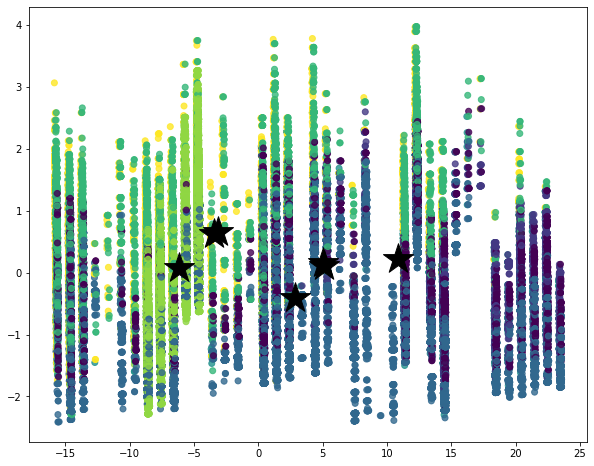

In [8]:
gp_cen = modelg.means_
plotscatter(gp_cen,test_data,y_pg,modelg,174304)

In [15]:
out = output.to_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv",index = False)

In [16]:
reading = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
reading

,id,target
0,0,3
1,1,4
2,2,3
3,3,4
4,4,3
...,...,...
174299,174299,1
174300,174300,6
174301,174301,3
174302,174302,6


In [17]:
reading['target'].value_counts()

3    70072
6    54588
2    18592
5    10468
7     9409
1     5997
4     5178
Name: target, dtype: int64

# Run this : kmean

In [30]:
filename = '/content/drive/MyDrive/DMG_Assignment/Assignment_3/'
KM = pickle.load(open(filename+'kmeans.pkl', 'rb'))
y_predkm = KM.predict(X_train)
arrkm , mc1 = getdict(X_train,y_train,y_predkm)
y_pred = pred(test_data,KM,mc1)

In [33]:
output = pd.read_csv("/content/drive/MyDrive/DMG_Assignment/Assignment_3/test_set_target_sample.csv")
output['target'] = y_pred
output['target'].value_counts()

2    87136
0    87110
6       40
1       18
Name: target, dtype: int64